In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from scipy.stats import norm
import random
import copy

In [2]:
class Particle:
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
        
    def motion_update(self, nu, time, noise_rate_pdf): 
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns*math.sqrt(abs(nu)/time)
        self.pose = IdealRobot.state_transition(pnu, time, self.pose)
        
    def observation_update(self, observation, envmap, distance_dev_rate): 
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]

            pos_on_map = envmap.landmarks[obs_id].pos
            particle_suggest_pos = IdealCamera.observation_function(self.pose, pos_on_map)
            
            distance_dev = distance_dev_rate*particle_suggest_pos
            self.weight *= norm.pdf(obs_pos, loc=0, scale=distance_dev) #ガウス分布

In [3]:
class Mcl:  
    def __init__(self, envmap, init_pose, num,
        motion_noise_stds=0.15, distance_dev_rate = 0.8):
        self.particles = [Particle(init_pose, 1.0/num) for i in range(num)]
        self.map = envmap
        self.distance_dev_rate = distance_dev_rate   
        
        self.motion_noise_rate_pdf = norm(loc=0.0, scale=motion_noise_stds) #ガウス分布

    def motion_update(self, nu, time):
        for p in self.particles:
            p.motion_update(nu, time, self.motion_noise_rate_pdf)
    
    
    def observation_update(self, observation):  
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate)
        self.resampling()
            
    def resampling(self): 
        ws = [e.weight for e in self.particles] 
        if sum(ws) < 1e-100: ws = [e + 1e-100 for e in ws]  
        ps = random.choices(self.particles, weights=ws, k=len(self.particles)) 
        self.particles = [copy.deepcopy(e) for e in ps] 
        for p in self.particles: p.weight = 1.0/len(self.particles)     
            
    def draw(self, ax, elems): 
        xs = [p.pose for p in self.particles]
        ys = [0] * len(self.particles)
        vxs = [p.weight for p in self.particles] 
        vys = [0] * len(self.particles) 
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class EstimationAgent(Agent): 
    def __init__(self, time_interval, nu, estimator): 
        super().__init__(nu)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        
    def decision(self, observation=None): 
        self.estimator.motion_update(self.prev_nu, self.time_interval)
        self.prev_nu = self.nu
        self.estimator.observation_update(observation)
        return self.nu
    
    def draw(self, ax, elems):  
        self.estimator.draw(ax, elems)

<IPython.core.display.Javascript object>


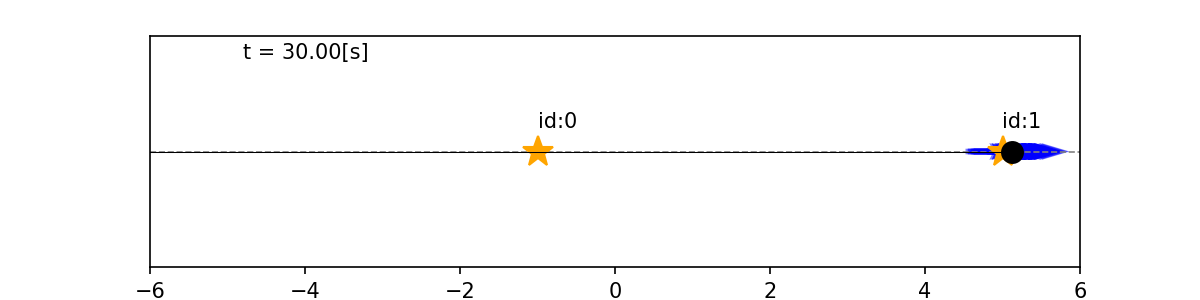

In [5]:
def trial(): 
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    m = Map()
    m.append_landmark(Landmark(-1))
    m.append_landmark(Landmark(5))
    world.append(m)          
    
    initial_pose = -6
    estimator = Mcl(m, initial_pose, 100) 
    a = EstimationAgent(time_interval, 0.4, estimator)
    r = Robot(initial_pose, sensor=Camera(m), agent=a)
    world.append(r)

    world.draw()
    
trial()